# Imports and configs

In [1]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import shutil
import optuna
import glob
import json
import os
import gc

warnings.filterwarnings("ignore")

In [2]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e3/train.csv"
    test_path = "/kaggle/input/playground-series-s5e3/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e3/sample_submission.csv"
    
    original_path = "/kaggle/input/hongkongrainfall/hongkong.csv"
    original_path_2 = "/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv"
    
    target = "rainfall"
    n_folds = 10
    seed = 2100
    
    run_optuna = True
    optuna_trials = 500

# Data loading and preprocessing

In [3]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

In [4]:
test.winddirection = test.winddirection.fillna(test.winddirection.median())

In [5]:
original = pd.read_csv(CFG.original_path, encoding="gbk")
original["date"] = pd.to_datetime(original[["year", "month", "day"]])
original = original.drop(["year", "month", "day", "low visibility hour", "radiation", "evaporation"], axis=1)
original["day"] = original.date.dt.dayofyear
original = original.drop("date", axis=1)
original.rainfall = original.rainfall.apply(lambda x: 1 if str(x).replace('.', '', 1).isdigit() else x)
original.rainfall = original.rainfall.replace({'微量': 1, '-': 0}).astype(int)
original.sunshine = original.sunshine.replace('-', 0).astype(float)
original.windspeed = original.windspeed.fillna(original.windspeed.mean())
for col in original.columns:
    original[col] = original[col].astype(train[col].dtype)

In [6]:
original_2 = pd.read_csv(CFG.original_path_2)
original_2.columns = original_2.columns.str.replace(" ", "")
original_2[CFG.target] = original_2[CFG.target].map({"yes": 1, "no": 0})
original_2.winddirection = original_2.winddirection.fillna(original_2.winddirection.mean())
original_2.windspeed = original_2.windspeed.fillna(original_2.windspeed.mean())
original_2.day = original_2.index + 1
for col in original_2.columns:
    original_2[col] = original_2[col].astype(train[col].dtype)

In [7]:
original_combined = pd.concat([original, original_2], axis=0).reset_index(drop=True)
original_combined = original_combined.drop_duplicates().reset_index(drop=True)

In [8]:
X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.copy()

X_original = original_combined.drop(CFG.target, axis=1)
y_original = original_combined[CFG.target]

# Training base models

In [9]:
os.makedirs("oof_files", exist_ok=True)

In [10]:
class Trainer:
    def __init__(self, model, config=CFG, is_ensemble_model=False):
        self.model = model
        self.config = config
        self.is_ensemble_model = is_ensemble_model

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = KFold(n_splits=self.config.n_folds)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            if X_original is not None and y_original is not None:                            
                X_train = pd.concat([X_train, X_original], ignore_index=True)
                y_train = pd.concat([y_train, y_original], ignore_index=True)
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble_model:
                coeffs += model.coef_ / self.config.n_folds
                if isinstance(self.model, LogisticRegression):
                    n_iters = model.n_iter_[0]
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[: ,1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if self.is_ensemble_model and isinstance(self.model, LogisticRegression):
                print(f"--- Fold {fold_idx + 1} - ROC AUC: {score:.6f} ({n_iters} iterations)")
            else:
                print(f"--- Fold {fold_idx + 1} - ROC AUC: {score:.6f}")
            
        overall_score = roc_auc_score(y, oof_pred_probs)
            
        print(f"\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        if self.is_ensemble_model:
            return oof_pred_probs, test_pred_probs, overall_score, scores, coeffs
        else:
            self._save_oof_files(oof_pred_probs, test_pred_probs, overall_score)
            return oof_pred_probs, test_pred_probs, overall_score, scores
        
    def tune(self, X, y):             
        oof_pred_probs = np.zeros(X.shape[0])
        skf = KFold(n_splits=self.config.n_folds)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[: ,1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return roc_auc_score(y, oof_pred_probs)
        
    def _save_oof_files(self, oof_pred_probs, test_pred_probs, cv_score):
        dirname = self.model.__class__.__name__.lower().replace("classifier", "")
        if (isinstance(self.model, LGBMClassifier)):
            if self.model.boosting_type == "goss":
                dirname += "-goss"
        os.makedirs(f"oof_files/{dirname}", exist_ok=True)
        joblib.dump(oof_pred_probs, f"oof_files/{dirname}/{dirname}_oof_pred_probs_{cv_score:.6f}.pkl")
        joblib.dump(test_pred_probs, f"oof_files/{dirname}/{dirname}_test_pred_probs_{cv_score:.6f}.pkl")

In [11]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f"sub_{name}_{score:.6f}.csv", index=False)
    return sub.head()

In [12]:
scores = {}
overall_scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
xgb_params = {
    "colsample_bylevel": 0.5612771472626059,
    "colsample_bynode": 0.4476365964992831,
    "colsample_bytree": 0.8282789650373276,
    "gamma": 9.231524513670266,
    "learning_rate": 0.02784964071709596,
    "max_depth": 444,
    "max_leaves": 488,
    "min_child_weight": 44,
    "n_estimators": 4693,
    "n_jobs": -1,
    "random_state": 2100,
    "reg_alpha": 6.499072336595235,
    "reg_lambda": 7.974348220513717,
    "subsample": 0.9516688112265111,
    "verbosity": 0
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.8295317151727176,
    "learning_rate": 0.006188413078211064,
    "min_child_samples": 355,
    "min_child_weight": 0.27719228244004235,
    "n_estimators": 727,
    "n_jobs": -1,
    "num_leaves": 219,
    "random_state": 2100,
    "reg_alpha": 15.548629166272775,
    "reg_lambda": 14.716040108980389,
    "subsample": 0.101737955307606,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.6000833078406066,
    "learning_rate": 0.003240994903669534,
    "min_child_samples": 97,
    "min_child_weight": 0.46731751033260494,
    "n_estimators": 1287,
    "n_jobs": -1,
    "num_leaves": 148,
    "random_state": 2100,
    "reg_alpha": 6.8478935000912955,
    "reg_lambda": 47.48804215347479,
    "subsample": 0.6177131563579147,
    "verbose": -1
}

cb_params = {
    "border_count": 192,
    "colsample_bylevel": 0.5567099308820974,
    "depth": 6,
    "iterations": 107,
    "l2_leaf_reg": 83.46883535314576,
    "learning_rate": 0.09209461884685786,
    "min_child_samples": 159,
    "random_state": 2100,
    "random_strength": 0.6484737768697515,
    "subsample": 0.6870109762903787,
    "verbose": False
}

adb_params = {
    "learning_rate": 0.0269705893361577,
    "n_estimators": 325,
    "random_state": 2100
}

rf_params = {
    "min_samples_leaf": 9,
    "min_samples_split": 4,
    "n_estimators": 279,
    "n_jobs": -1,
    "random_state": 2100
}

et_params = {
    "class_weight": None,
    "criterion": "log_loss",
    "min_samples_leaf": 1,
    "min_samples_split": 80,
    "n_estimators": 870,
    "n_jobs": -1,
    "random_state": 2100
}

histgb_params = {
    "l2_regularization": 5.130665645265864,
    "learning_rate": 0.01967391588679309,
    "max_depth": 214,
    "max_iter": 147,
    "max_leaf_nodes": 310,
    "min_samples_leaf": 426,
    "random_state": 2100
}

gb_params = {
    "learning_rate": 0.02345716366238361,
    "max_depth": 12,
    "max_features": 0.7178155322621119,
    "max_leaf_nodes": 2,
    "min_samples_leaf": 0.07664587560952951,
    "min_samples_split": 0.11992580568881415,
    "min_weight_fraction_leaf": 0.020660268974460272,
    "n_estimators": 532,
    "random_state": 2100,
    "subsample": 0.9553512333424752
}

lr_params = {
    "random_state": 2100,
    "max_iter": 500,
    "C": 96.93165468916811,
    "tol": 0.0046669720495905904,
    "fit_intercept": True,
    "class_weight": None,
    "solver": "liblinear",
    "penalty": "l1"
}

ridge_params = {
    "random_state": 2100,
    "alpha": 11.157283825931083,
    "tol": 0.009179273943953294,
    "positive": False,
    "fit_intercept": False
}

In [14]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], overall_scores["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training XGBClassifier

--- Fold 1 - ROC AUC: 0.910533
--- Fold 2 - ROC AUC: 0.867842
--- Fold 3 - ROC AUC: 0.904262
--- Fold 4 - ROC AUC: 0.930666
--- Fold 5 - ROC AUC: 0.919780
--- Fold 6 - ROC AUC: 0.912497
--- Fold 7 - ROC AUC: 0.897379
--- Fold 8 - ROC AUC: 0.877671
--- Fold 9 - ROC AUC: 0.880925
--- Fold 10 - ROC AUC: 0.870707

------ Overall: 0.897449 | Average: 0.897226 ± 0.020740


In [15]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_pred_probs["LightGBM"], test_pred_probs["LightGBM"], overall_scores["LightGBM"], scores["LightGBM"] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - ROC AUC: 0.913018
--- Fold 2 - ROC AUC: 0.864823
--- Fold 3 - ROC AUC: 0.905119
--- Fold 4 - ROC AUC: 0.928268
--- Fold 5 - ROC AUC: 0.921978
--- Fold 6 - ROC AUC: 0.908490
--- Fold 7 - ROC AUC: 0.890985
--- Fold 8 - ROC AUC: 0.875870
--- Fold 9 - ROC AUC: 0.875036
--- Fold 10 - ROC AUC: 0.869248

------ Overall: 0.896199 | Average: 0.895284 ± 0.021903


In [16]:
lgbm_goss_model = LGBMClassifier(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], overall_scores["LightGBM (goss)"], scores["LightGBM (goss)"] = lgbm_goss_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - ROC AUC: 0.912071
--- Fold 2 - ROC AUC: 0.860732
--- Fold 3 - ROC AUC: 0.902120
--- Fold 4 - ROC AUC: 0.924500
--- Fold 5 - ROC AUC: 0.915385
--- Fold 6 - ROC AUC: 0.910548
--- Fold 7 - ROC AUC: 0.896541
--- Fold 8 - ROC AUC: 0.875030
--- Fold 9 - ROC AUC: 0.875836
--- Fold 10 - ROC AUC: 0.870034

------ Overall: 0.895155 | Average: 0.894280 ± 0.021049


In [17]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)
oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], overall_scores["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training CatBoostClassifier

--- Fold 1 - ROC AUC: 0.908757
--- Fold 2 - ROC AUC: 0.856739
--- Fold 3 - ROC AUC: 0.903084
--- Fold 4 - ROC AUC: 0.929433
--- Fold 5 - ROC AUC: 0.919181
--- Fold 6 - ROC AUC: 0.910548
--- Fold 7 - ROC AUC: 0.897694
--- Fold 8 - ROC AUC: 0.874310
--- Fold 9 - ROC AUC: 0.886595
--- Fold 10 - ROC AUC: 0.863412

------ Overall: 0.895903 | Average: 0.894975 ± 0.022879


In [18]:
adb_model = AdaBoostClassifier(**adb_params)
adb_trainer = Trainer(adb_model)
oof_pred_probs["AdaBoost"], test_pred_probs["AdaBoost"], overall_scores["AdaBoost"], scores["AdaBoost"] = adb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training AdaBoostClassifier

--- Fold 1 - ROC AUC: 0.911183
--- Fold 2 - ROC AUC: 0.861560
--- Fold 3 - ROC AUC: 0.902656
--- Fold 4 - ROC AUC: 0.923404
--- Fold 5 - ROC AUC: 0.917083
--- Fold 6 - ROC AUC: 0.902859
--- Fold 7 - ROC AUC: 0.885325
--- Fold 8 - ROC AUC: 0.879352
--- Fold 9 - ROC AUC: 0.868058
--- Fold 10 - ROC AUC: 0.879125

------ Overall: 0.892773 | Average: 0.893060 ± 0.020183


In [19]:
rf_model = RandomForestClassifier(**rf_params)
rf_trainer = Trainer(rf_model)
oof_pred_probs["RandomForest"], test_pred_probs["RandomForest"], overall_scores["RandomForest"], scores["RandomForest"] = rf_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training RandomForestClassifier

--- Fold 1 - ROC AUC: 0.905680
--- Fold 2 - ROC AUC: 0.861219
--- Fold 3 - ROC AUC: 0.902442
--- Fold 4 - ROC AUC: 0.925185
--- Fold 5 - ROC AUC: 0.912587
--- Fold 6 - ROC AUC: 0.917371
--- Fold 7 - ROC AUC: 0.882495
--- Fold 8 - ROC AUC: 0.864466
--- Fold 9 - ROC AUC: 0.892120
--- Fold 10 - ROC AUC: 0.861616

------ Overall: 0.892743 | Average: 0.892518 ± 0.022763


In [20]:
et_model = ExtraTreesClassifier(**et_params)
et_trainer = Trainer(et_model)
oof_pred_probs["ExtraTrees"], test_pred_probs["ExtraTrees"], overall_scores["ExtraTrees"], scores["ExtraTrees"] = et_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training ExtraTreesClassifier

--- Fold 1 - ROC AUC: 0.908047
--- Fold 2 - ROC AUC: 0.857421
--- Fold 3 - ROC AUC: 0.904798
--- Fold 4 - ROC AUC: 0.929570
--- Fold 5 - ROC AUC: 0.913786
--- Fold 6 - ROC AUC: 0.917154
--- Fold 7 - ROC AUC: 0.895073
--- Fold 8 - ROC AUC: 0.872269
--- Fold 9 - ROC AUC: 0.885432
--- Fold 10 - ROC AUC: 0.866218

------ Overall: 0.895487 | Average: 0.894977 ± 0.022702


In [21]:
histgb_model = HistGradientBoostingClassifier(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_pred_probs["HistGradientBoosting"], test_pred_probs["HistGradientBoosting"], overall_scores["HistGradientBoosting"], scores["HistGradientBoosting"] = histgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training HistGradientBoostingClassifier

--- Fold 1 - ROC AUC: 0.909408
--- Fold 2 - ROC AUC: 0.865991
--- Fold 3 - ROC AUC: 0.901264
--- Fold 4 - ROC AUC: 0.931625
--- Fold 5 - ROC AUC: 0.923077
--- Fold 6 - ROC AUC: 0.919753
--- Fold 7 - ROC AUC: 0.886426
--- Fold 8 - ROC AUC: 0.876471
--- Fold 9 - ROC AUC: 0.874818
--- Fold 10 - ROC AUC: 0.872503

------ Overall: 0.896997 | Average: 0.896134 ± 0.022690


In [22]:
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
oof_pred_probs["GradientBoosting"], test_pred_probs["GradientBoosting"], overall_scores["GradientBoosting"], scores["GradientBoosting"] = gb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training GradientBoostingClassifier

--- Fold 1 - ROC AUC: 0.909408
--- Fold 2 - ROC AUC: 0.862291
--- Fold 3 - ROC AUC: 0.901049
--- Fold 4 - ROC AUC: 0.925116
--- Fold 5 - ROC AUC: 0.916484
--- Fold 6 - ROC AUC: 0.905891
--- Fold 7 - ROC AUC: 0.892558
--- Fold 8 - ROC AUC: 0.883073
--- Fold 9 - ROC AUC: 0.874382
--- Fold 10 - ROC AUC: 0.875533

------ Overall: 0.895517 | Average: 0.894579 ± 0.019369


In [23]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)
oof_pred_probs["LogisticRegression"], test_pred_probs["LogisticRegression"], overall_scores["LogisticRegression"], scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LogisticRegression

--- Fold 1 - ROC AUC: 0.902604
--- Fold 2 - ROC AUC: 0.847487
--- Fold 3 - ROC AUC: 0.902656
--- Fold 4 - ROC AUC: 0.914908
--- Fold 5 - ROC AUC: 0.907293
--- Fold 6 - ROC AUC: 0.904808
--- Fold 7 - ROC AUC: 0.892767
--- Fold 8 - ROC AUC: 0.884994
--- Fold 9 - ROC AUC: 0.878744
--- Fold 10 - ROC AUC: 0.886756

------ Overall: 0.892790 | Average: 0.892302 ± 0.018390


In [24]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
oof_pred_probs["Ridge"], test_pred_probs["Ridge"], overall_scores["Ridge"], scores["Ridge"] = ridge_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training Ridge

--- Fold 1 - ROC AUC: 0.901657
--- Fold 2 - ROC AUC: 0.849143
--- Fold 3 - ROC AUC: 0.904262
--- Fold 4 - ROC AUC: 0.915182
--- Fold 5 - ROC AUC: 0.910589
--- Fold 6 - ROC AUC: 0.906000
--- Fold 7 - ROC AUC: 0.892767
--- Fold 8 - ROC AUC: 0.879472
--- Fold 9 - ROC AUC: 0.884996
--- Fold 10 - ROC AUC: 0.893939

------ Overall: 0.893235 | Average: 0.893801 ± 0.018268


In [25]:
tabpfn_model = TabPFNClassifier(random_state=CFG.seed, n_jobs=-1)
tabpfn_trainer = Trainer(tabpfn_model)
oof_pred_probs["TabPFN"], test_pred_probs["TabPFN"], overall_scores["TabPFN"], scores["TabPFN"] = tabpfn_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training TabPFNClassifier



tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

--- Fold 1 - ROC AUC: 0.909112
--- Fold 2 - ROC AUC: 0.856642
--- Fold 3 - ROC AUC: 0.900407
--- Fold 4 - ROC AUC: 0.922719
--- Fold 5 - ROC AUC: 0.908292
--- Fold 6 - ROC AUC: 0.914338
--- Fold 7 - ROC AUC: 0.894759
--- Fold 8 - ROC AUC: 0.875750
--- Fold 9 - ROC AUC: 0.892992
--- Fold 10 - ROC AUC: 0.860157

------ Overall: 0.892999 | Average: 0.893517 ± 0.021413


# Ensembling with LogisticRegression

In [26]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.3))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [27]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [28]:
def objective(trial):
    solver_penalty_options = [
        ("liblinear", "l1"),
        ("liblinear", "l2"),
        ("lbfgs", "l2"),
        ("lbfgs", None),
        ("newton-cg", "l2"),
        ("newton-cg", None),
        ("newton-cholesky", "l2"),
        ("newton-cholesky", None)
    ]
    solver, penalty = trial.suggest_categorical("solver_penalty", solver_penalty_options)
    
    params = {
        "random_state": CFG.seed,
        "max_iter": 500,
        "C": trial.suggest_float("C", 0, 100),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
        "solver": solver,
        "penalty": penalty
    }
    
    model = LogisticRegression(**params)
    trainer = Trainer(model, is_ensemble_model=True)
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True, n_startup_trials=CFG.optuna_trials // 10)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.optuna_trials, n_jobs=-1)
    best_params = study.best_params
    
    solver, penalty = best_params["solver_penalty"]
    lr_params = {
        "random_state": CFG.seed,
        "max_iter": 500,
        "C": best_params["C"],
        "tol": best_params["tol"],
        "fit_intercept": best_params["fit_intercept"],
        "class_weight": best_params["class_weight"],
        "solver": solver,
        "penalty": penalty
    }
else:
    lr_params = {
      "random_state": 42
    }

[I 2025-03-15 20:08:13,314] A new study created in memory with name: no-name-4a62fca1-7a57-49f3-b5ea-812d6e665874
[I 2025-03-15 20:08:18,990] Trial 1 finished with value: 0.8952199775533107 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 92.49338932477876, 'tol': 0.0013856087110250001, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8952199775533107.
[I 2025-03-15 20:08:20,789] Trial 3 finished with value: 0.8948585858585858 and parameters: {'solver_penalty': ('newton-cholesky', 'l2'), 'C': 67.47246216813116, 'tol': 0.00624997276703723, 'fit_intercept': True, 'class_weight': None}. Best is trial 1 with value: 0.8952199775533107.
[I 2025-03-15 20:08:22,499] Trial 2 finished with value: 0.8947665544332211 and parameters: {'solver_penalty': ('newton-cholesky', 'l2'), 'C': 45.0588501545609, 'tol': 0.0008568522147177427, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8952199775533107.
[I 2025-03-15 20:08:26,22

In [29]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 2100,
  "max_iter": 500,
  "C": 0.9602168651900964,
  "tol": 0.008188462186567937,
  "fit_intercept": false,
  "class_weight": null,
  "solver": "lbfgs",
  "penalty": "l2"
}


In [30]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model, is_ensemble_model=True)
lr_oof_pred_probs, lr_test_pred_probs, overall_scores["Ensemble LR"], scores["Ensemble LR"], lr_coeffs = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - ROC AUC: 0.911124 (9 iterations)
--- Fold 2 - ROC AUC: 0.861804 (9 iterations)
--- Fold 3 - ROC AUC: 0.905440 (7 iterations)
--- Fold 4 - ROC AUC: 0.929296 (8 iterations)
--- Fold 5 - ROC AUC: 0.918581 (9 iterations)
--- Fold 6 - ROC AUC: 0.913580 (8 iterations)
--- Fold 7 - ROC AUC: 0.894759 (8 iterations)
--- Fold 8 - ROC AUC: 0.878992 (8 iterations)
--- Fold 9 - ROC AUC: 0.884996 (8 iterations)
--- Fold 10 - ROC AUC: 0.873625 (9 iterations)

------ Overall: 0.897107 | Average: 0.897220 ± 0.020767


In [31]:
save_submission("ensemble-lr", lr_test_pred_probs, np.mean(scores["Ensemble LR"]))

,id,rainfall
0,2190,0.992428
1,2191,0.994013
2,2192,0.944688
3,2193,0.133573
4,2194,0.084464


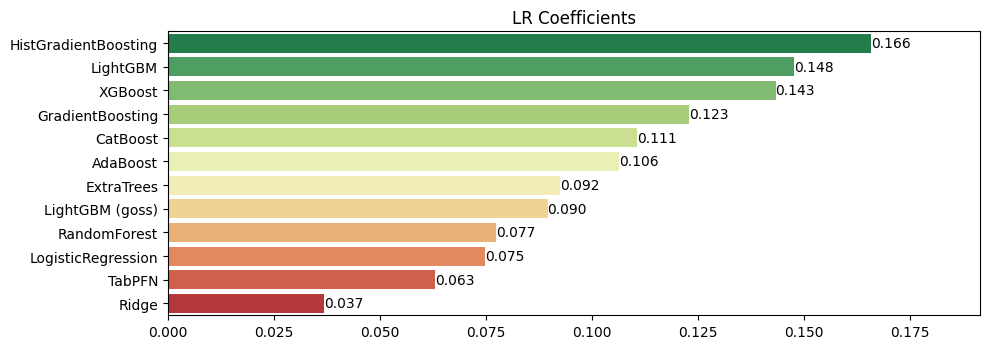

In [32]:
plot_weights(lr_coeffs, "LR Coefficients")

# Ensembling with Ridge

In [33]:
X = pd.DataFrame(oof_pred_probs)
X_test = pd.DataFrame(test_pred_probs)

In [34]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 25),
        "tol": trial.suggest_float("tol", 1e-7, 1e-2),
        "positive": trial.suggest_categorical("positive", [True, False]),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False])
    }
    
    model = Ridge(**params)
    trainer = Trainer(model, is_ensemble_model=True)
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True, n_startup_trials=CFG.optuna_trials // 10)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.optuna_trials, n_jobs=-1)
    best_params = study.best_params
    
    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"],
        "positive": best_params["positive"],
        "fit_intercept": best_params["fit_intercept"]
    }
else:
    ridge_params = {
      "random_state": 42
    }

[I 2025-03-15 20:26:59,395] A new study created in memory with name: no-name-8fdbb49f-7d0a-4f9b-9fae-e98b87ee7e75
[I 2025-03-15 20:27:04,573] Trial 0 finished with value: 0.8968776655443322 and parameters: {'alpha': 19.547646550036397, 'tol': 0.005640651294902485, 'positive': False, 'fit_intercept': True}. Best is trial 0 with value: 0.8968776655443322.
[I 2025-03-15 20:27:08,972] Trial 1 finished with value: 0.8970056116722783 and parameters: {'alpha': 10.380812692170943, 'tol': 0.005501084486004469, 'positive': True, 'fit_intercept': False}. Best is trial 1 with value: 0.8970056116722783.
[I 2025-03-15 20:27:09,173] Trial 3 finished with value: 0.8969360269360269 and parameters: {'alpha': 5.319096814935187, 'tol': 0.003596370004661086, 'positive': True, 'fit_intercept': False}. Best is trial 1 with value: 0.8970056116722783.
[I 2025-03-15 20:27:09,189] Trial 2 finished with value: 0.897006734006734 and parameters: {'alpha': 13.107485306638415, 'tol': 0.003565532612651813, 'positive':

In [35]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 2100,
  "alpha": 8.014765966227701,
  "tol": 0.009906730286180552,
  "positive": true,
  "fit_intercept": false
}


In [36]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model, is_ensemble_model=True)
lr_oof_pred_probs, lr_test_pred_probs, overall_scores["Ensemble Ridge"], scores["Ensemble Ridge"], ridge_coeffs = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 1 - ROC AUC: 0.910769
--- Fold 2 - ROC AUC: 0.864238
--- Fold 3 - ROC AUC: 0.904798
--- Fold 4 - ROC AUC: 0.928474
--- Fold 5 - ROC AUC: 0.917483
--- Fold 6 - ROC AUC: 0.911848
--- Fold 7 - ROC AUC: 0.895388
--- Fold 8 - ROC AUC: 0.878752
--- Fold 9 - ROC AUC: 0.886304
--- Fold 10 - ROC AUC: 0.875645

------ Overall: 0.897172 | Average: 0.897370 ± 0.019644


In [37]:
save_submission("ensemble-ridge", lr_test_pred_probs, np.mean(scores["Ensemble Ridge"]))

,id,rainfall
0,2190,0.991463
1,2191,0.993843
2,2192,0.930565
3,2193,0.186721
4,2194,0.134877


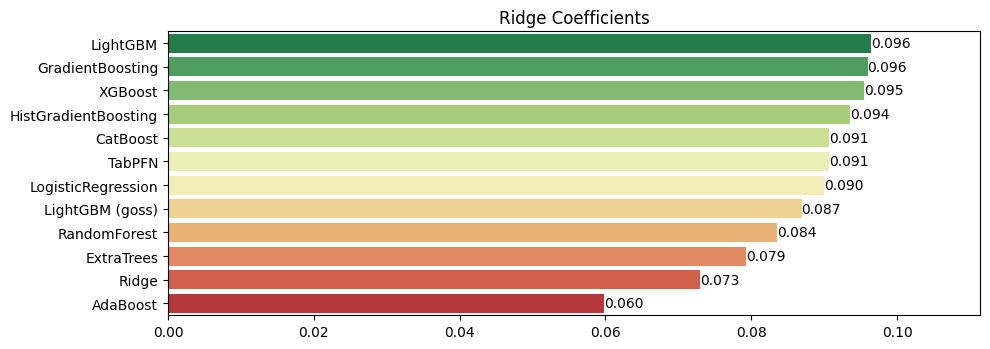

In [38]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

# Results

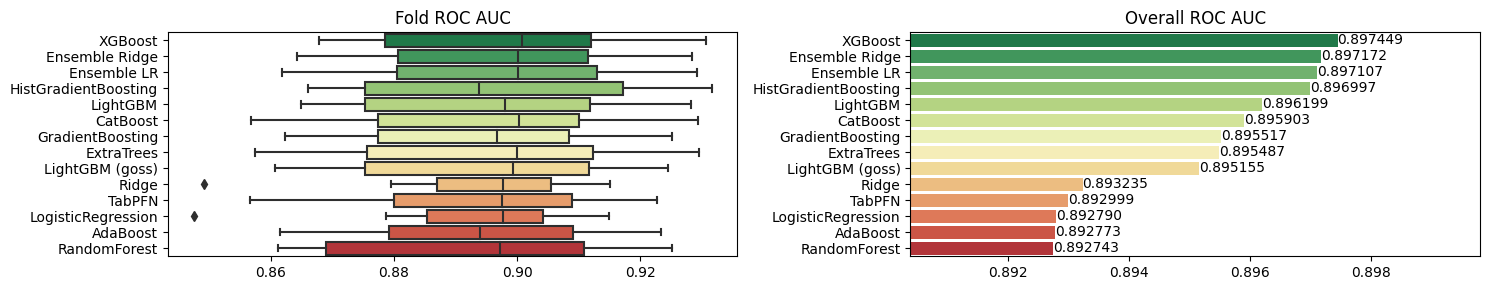

In [39]:
scores_df = pd.DataFrame(scores)
overall_scores_series = pd.Series({k: v for k, v in overall_scores.items()})
order = overall_scores_series.sort_values(ascending=False).index.tolist()

min_score = overall_scores_series.min()
max_score = overall_scores_series.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, len(scores_df) * 0.3))

sns.boxplot(data=scores_df, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold ROC AUC")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores_series, y=overall_scores_series.index, ax=axs[1], palette="RdYlGn_r", order=order)
axs[1].set_title("Overall ROC AUC")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(overall_scores_series[order]):
    barplot.text(score, i, f"{score:.6f}", va="center")

plt.tight_layout()
plt.show()

In [40]:
shutil.rmtree("catboost_info", ignore_errors=True)